In [55]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [56]:
train = pd.read_csv('../data/train.csv', index_col='id')
test = pd.read_csv('../data/test.csv', index_col='id')
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def df_preview(df):
    for col in df.columns:
        print(col, "null count ::", df[col].isnull().sum(), "// mean ::", df[col].mean())

def df_col_distplot(df):
    for col in df.columns:
        print(col, "plot")
        sns.distplot(df.loc[df[col].notnull(), col])
        plt.title(col)
        plt.show()

def rmse_expm1(pred, true):
    return -np.sqrt(np.mean((np.expm1(pred)-np.expm1(true))**2))

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

In [58]:
## concat_df: train, test 를 합친 dataframe

concat_df = pd.concat([train, test])
concat_df.shape

(20000, 75)

In [60]:
target_cols = ['hhb', 'hbo2', 'ca', 'na']

concat_train = concat_df[concat_df['hhb'].notnull()]
concat_test = concat_df[concat_df['hhb'].isnull()]

In [62]:
train_dst = concat_train.filter(regex='_dst$', axis=1).replace(0, np.NaN)
test_dst = concat_test.filter(regex='_dst$', axis=1).replace(0, np.NaN)

In [64]:
train_dst = train_dst.interpolate(method='linear', axis=1)
test_dst = test_dst.interpolate(method='linear',axis=1)
train_dst.fillna(0, inplace=True)
test_dst.fillna(0, inplace=True)

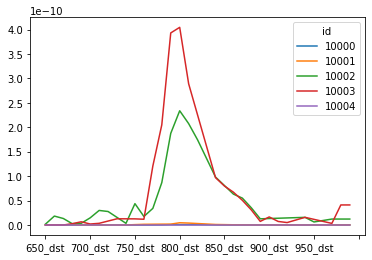

In [65]:
test_dst.head().T.plot()

In [66]:
concat_train.update(train_dst)
concat_test.update(test_dst)

In [68]:
concat_df = pd.concat([concat_train, concat_test])
concat_df.shape

(20000, 75)

In [69]:
dont_need_scale_cols = ['rho', 'hhb', 'hbo2', 'ca', 'na']
droped_df = concat_df.drop(dont_need_scale_cols, axis=1)

In [70]:
std_scaler = StandardScaler()
std_scaler.fit(droped_df)
scaled_feature = std_scaler.transform(droped_df)
scaled_feature = pd.DataFrame(scaled_feature, columns=droped_df.columns, index=list(droped_df.index.values))

In [72]:
concat_df.update(scaled_feature)

In [74]:
scaled_train = concat_df[concat_df['hhb'].notnull()]
scaled_test = concat_df[concat_df['hhb'].isnull()]

In [75]:
from sklearn.model_selection import KFold

folds = KFold(n_splits = 5, shuffle = True, random_state = 551)

In [76]:
import lightgbm as lgb

feature_col = scaled_train.columns.drop(['hhb', 'hbo2', 'ca', 'na'])
target_col_list = ['hhb', 'hbo2', 'ca', 'na']
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')

for target_col in target_col_list:
    print("target_col :: ",target_col)
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(scaled_train)):
        x_data = scaled_train[feature_col]
        y_data = scaled_train[target_col]

        train_X, train_y = x_data.iloc[trn_idx], y_data.iloc[trn_idx] 
        valid_X, valid_y = x_data.iloc[val_idx], y_data.iloc[val_idx]

        train_ds = lgb.Dataset(train_X, label=train_y)
        valid_ds = lgb.Dataset(valid_X, label=valid_y)

        params = {
            'objective':'regression', 
            'num_iterations':10**3, 
            'n_estimators': 2000,
            'metric': 'rmse',
        }

        model = lgb.train(
            params=params, 
            train_set=train_ds, 
            valid_sets=valid_ds, 
            verbose_eval=2000, 
            early_stopping_rounds=100 
        )

        test_x = scaled_test[feature_col]
        test_pred = model.predict(test_x)
        submission[target_col] = submission[target_col] + test_pred

target_col ::  hhb
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[960]	valid_0's rmse: 1.15142
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[965]	valid_0's rmse: 1.13294
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[522]	valid_0's rmse: 1.20111
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[986]	valid_0's rmse: 1.13832
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.19929
target_col ::  hbo2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[415]	valid_0's rmse: 0.794429
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[640]	valid_0's rmse: 0.805182
Training until va

In [77]:
submission = submission / 5
submission

,hhb,hbo2,ca,na
id,,,,
10000,8.809240,4.537848,8.945962,3.039534
10001,6.252589,3.552571,9.382630,2.911284
10002,9.930552,4.710298,10.749509,3.531731
10003,8.611735,4.335435,9.118581,3.775487
10004,5.541879,3.782341,8.855471,3.113823
...,...,...,...,...
19995,4.499268,3.739713,10.692145,4.039358
19996,11.759559,2.435220,7.522129,3.427775
19997,7.242471,3.446548,8.855734,3.141599


In [78]:
import time
filename = time.strftime('%Y-%m-%d-%H_%M_%S')+'submission.csv'
submission.to_csv(filename, index=True)